# Probabilistic Linear Inference

## The Continuous Problem

We consider the problem of inferring an unknown model parameter $m$ from noisy observations $\mathbf{\tilde{d}}$, where $m$ lies in a separable Hilbert space $\mathcal{M}$ and $\mathbf{\tilde{d}} \in \mathcal{D}$, a finite‑dimensional Euclidean data space $\mathcal{D} \cong \mathbb{R}^{N_d}$ ($N_d \in \mathbb{N}$ is the number of data).

The relationship between the model and the data is described by a forward operator:
$$
G: \mathcal{M} \to \mathcal{D}, \quad [G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
assumed to be linear and bounded. The observed data is modeled as:
$$
\mathbf{\tilde{d}} = G(m) + \bm{\eta},
$$
where $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$ represents additive Gaussian noise with known symmetric positive‑definite covariance matrix $\mathbf{C}_{\mathcal{D}} \in \mathbb{R}^{N_d \times N_d}$.

To regularize this ill‑posed inverse problem, we adopt a Bayesian framework. We model the unknown $m$ as a random variable and assign a Gaussian prior:
$$
m \sim \mu_{\mathcal{M}}^0 := \mathcal{N}(m_0, C_0),
$$
where $m_0 \in \mathcal{M}$ is the prior mean, and $C_0: \mathcal{M} \to \mathcal{M}$ is a symmetric, positive‑definite trace‑class covariance operator.


**Gaussian measure in terms of $C_0$**  
Under this formulation the Gaussian prior can be equivalently written via its Karhunen–Loève expansion: if $\{\varphi_k\}$ are eigenfunctions of $C_0$ with eigenvalues $\{\lambda_k\}$, then
$$
m = m_0 + \sum_{k=1}^\infty \sqrt{\lambda_k} \,\bm{\xi}_k\,\varphi_k,
\qquad
\bm{\xi}_k \overset{i.i.d.}{\sim} \mathcal{N}(0,1).
$$
Thus $C_0$ controls the decay of $\lambda_k$ and hence the regularity of samples from $\mu_{\mathcal{M}}^0$.

The goal of Bayesian inversion is to compute or characterize the posterior distribution $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ of $m$ conditioned on the observed data $\mathbf{\tilde{d}}$. According to Bayes’ theorem (in the infinite‑dimensional setting), the posterior is given formally by:
$$
\frac{d\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}}{d\mu_{\mathcal{M}}^0}(m) \;\propto\; \exp\!\left[-\tfrac12\,\|G(m)-\mathbf{\tilde{d}}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2\right],
$$
where the data‐misfit norm is
$$
\|\mathbf{v}\|_{\mathbf{C}^{-1}_{\mathcal{D}}}^2 := \mathbf{v}^\top\,\mathbf{C}_{\mathcal{D}}^{-1}\,\mathbf{v}.
$$

Bayesian inference takes this a step further and asks for a specific property of the true model. Let 
$$
\mathcal{T} \colon \mathcal{M} \to \mathcal{P}, \quad [\mathcal{T}(m)]_i = \langle T_i, m \rangle_{\mathcal{M}}
$$
be a linear and bounded mapping that takes in a model and outputs a finite number of real scalars that represent some local or global property of the model, such as a global average, a local average, a local gradient average, a Fourier basis coefficient, etc. $T_i \in \mathcal{M}$ are the target kernels. The property space $\mathcal{P}$ is a finite dimensional Hilbert space equivalent to $\mathbb{R}^{N_p}$ where $N_p \in \mathbb{N}$ is the number of "properties" to be sought. By pushing the infinite-dimensional posterior measure $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}$ through the property mapping $\mathcal{T}$ we obtain the (Gaussian) property measure 
$$
\mu_{\mathcal{P}} = \mathcal{T}_*\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}}
$$

## Continuous Solution

Using a Bayesian update we obtain the posterior measure on the model space $\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$ where:
$$
\boxed{
C_{\mathcal{M}} = \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1} \right)^{-1}, \quad
\tilde{m} = C_{\mathcal{M}} \left( G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1}m_0 \right).
}
$$

Then we can obtain the property measure from the model posterior $\mu_{\mathcal{P}} = \mathcal{N}(\mathbf{\tilde{p}}, \mathbf{C}_{\mathcal{P}})$:
$$
\boxed{
\mathbf{\tilde{p}} = \mathcal{T}(\tilde{m}), \quad \mathbf{C}_{\mathcal{P}} = \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*.
}
$$


### Importing the necessary packages

In [1]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


## Creating the spaces

We first create the function domain as an interval. The model space will be an $L^2$ space with $N$ basis function of type fourier. 

In [2]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
N = 20 # number of basis functions
M = L2Space(N, function_domain, basis_type='sine') # model space
N_d = 100 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

Then we create a set of sensitivity kernels for the forward map, and target kernels for the property map and use them to instantiate the operators.

In [3]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=1000)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=1000)

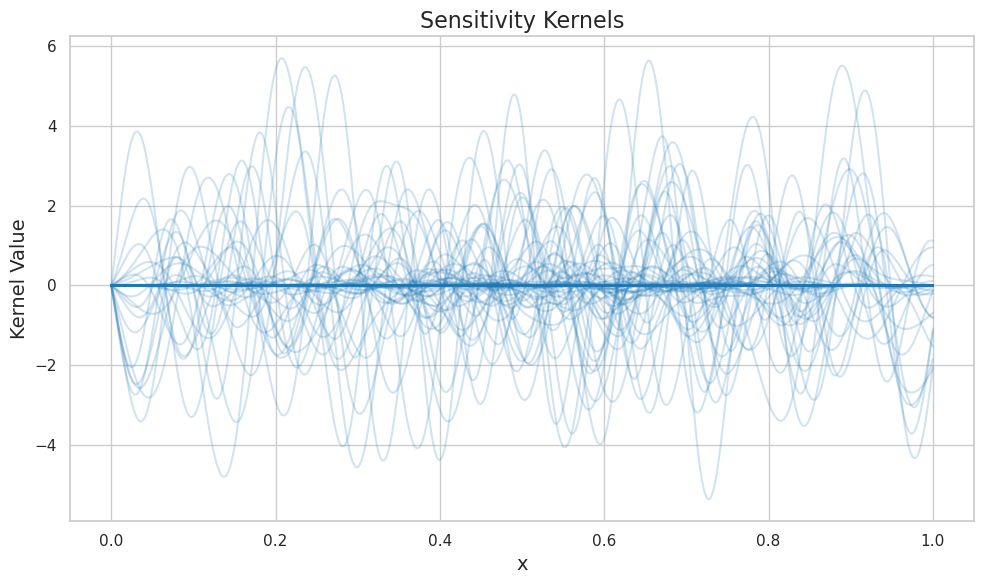

In [4]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))
for i in range(N_d):
    plt.plot(x, G.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.2)
plt.title('Sensitivity Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

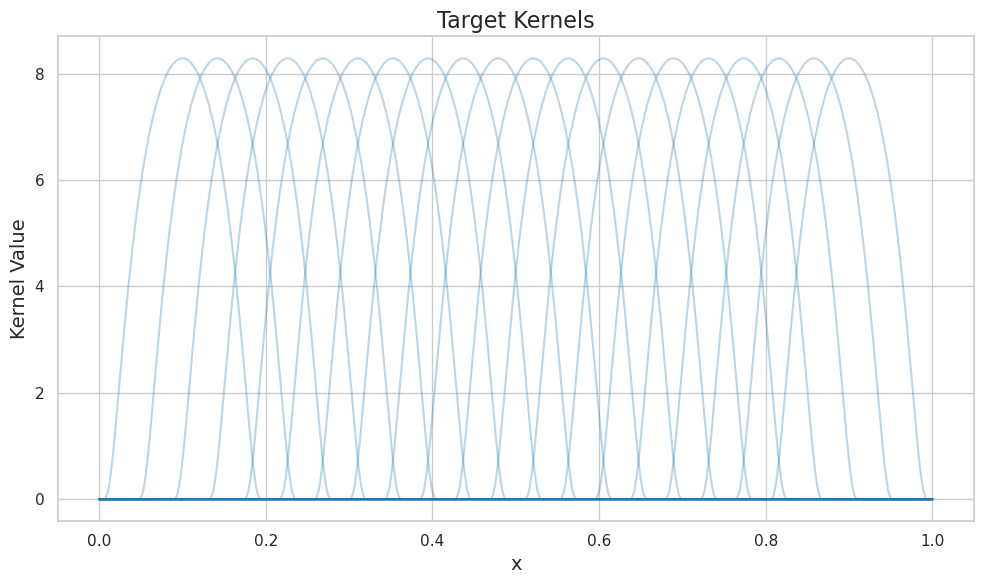

In [5]:
plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, T.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('Target Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

## Create true model, data, and measurement
We create a true model $\bar{m}$ and the coresponding data $\mathbf{\bar{d}}$. We also create the noisy data $\mathbf{\tilde d}$ that reprsents our measurement.

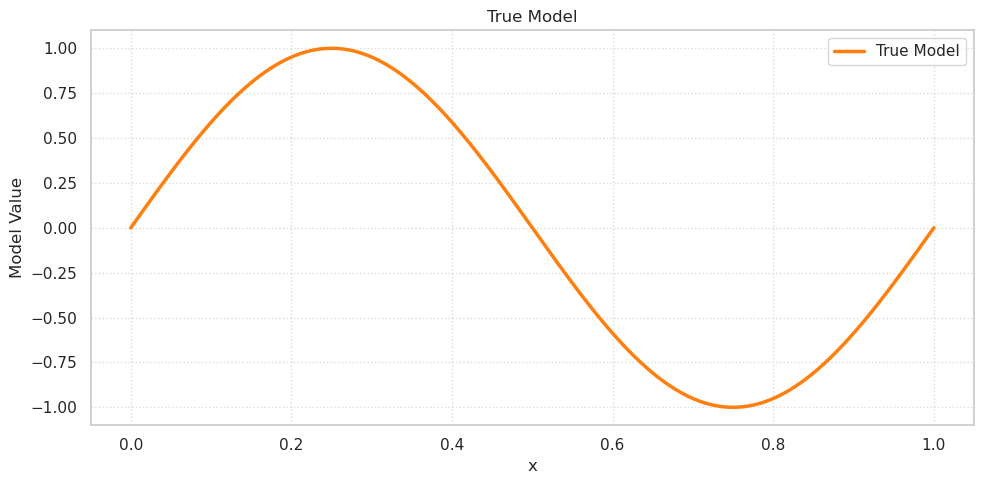

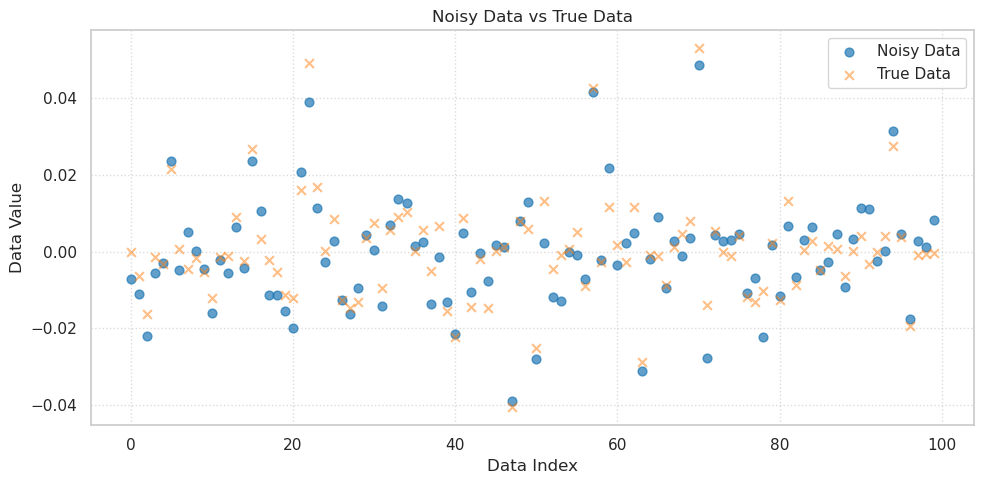

In [6]:
# Create a true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))

# Plot the true model
plt.figure(figsize=(10, 5))
plt.plot(x, m_bar.evaluate(x), label='True Model', color='tab:orange', linewidth=2.5)
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# Create corresponding data
d_bar = G(m_bar)
# Create noisy data
d_tilde = d_bar + np.random.normal(0, 0.1 * np.max(d_bar), d_bar.shape)

# Plot noisy and true data
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(d_bar)), d_tilde, label='Noisy Data', color='tab:blue', alpha=0.7, marker='o', s=40)
plt.scatter(np.arange(len(d_bar)), d_bar, label='True Data', color='tab:orange', alpha=0.5, marker='x', s=40)
plt.xlabel('Data Index')
plt.ylabel('Data Value')
plt.title('Noisy Data vs True Data')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## Create data measure
Now we create a covariance operator for the data measure (a simple diagonal covariance) and build the data measure. We use the noisy data as the expectation of our measure.

In [21]:
# Add Gaussian measure on data space
C_0_matrix = np.eye(N_d) * 0.01 * np.max(d_tilde)  # covariance matrix for the noise

# Use from_covariance_matrix which automatically enables sampling
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_0_matrix, expectation=d_tilde)

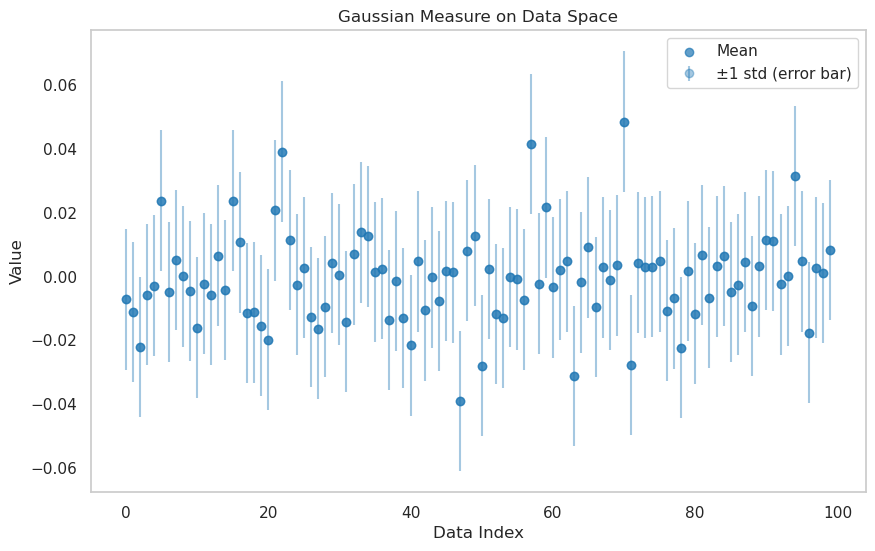

In [22]:
# Plot the Gaussian measure on the data space as a scatter plot
mean_values = gaussian_D.expectation
std_values = np.sqrt(np.diag(gaussian_D.covariance.matrix(dense=True)))

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(mean_values)), mean_values, label='Mean', color='tab:blue', alpha=0.7)
plt.errorbar(np.arange(len(mean_values)), mean_values, yerr=std_values, fmt='o', color='tab:blue', alpha=0.4, label='±1 std (error bar)')
plt.title('Gaussian Measure on Data Space')
plt.xlabel('Data Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

## Create Model prior measure

In [23]:
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
C_0 = LaplacianInverseOperator(M, bc_dirichlet, alpha=0.1)
m_0 = Function(M, evaluate_callable=lambda x: x)  # zero expectation
K = 500
M.create_gaussian_measure(method='kl',  kl_expansion=K, covariance=C_0, expectation=m_0)

DOLFINx found but has compatibility issues, using native solver
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs


Now we can test it by sampling from it

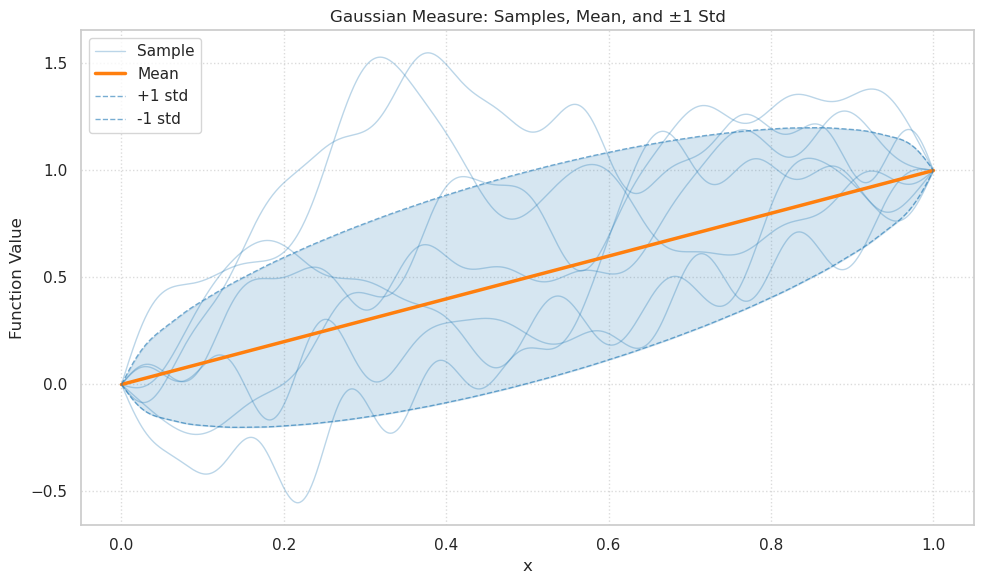

In [24]:
# Visualize samples, mean, and ±1 std of the Gaussian measure on the model space
num_samples = 7
sample_color = 'tab:blue'
mean_color = 'tab:orange'
std_color = 'tab:blue'

plt.figure(figsize=(10, 6))

# Plot a few samples
for _ in range(num_samples):
    plt.plot(x, M.gaussian_measure.sample().evaluate(x), color=sample_color, alpha=0.3, linewidth=1, label='Sample' if _ == 0 else "")

# Compute std
std = M.zero
for i, eigenvalue in enumerate(C_0.spectrum_provider.get_all_eigenvalues()[:100]):
    eigenfunction = C_0.spectrum_provider.get_eigenfunction(i)
    std += eigenvalue * eigenfunction * eigenfunction
std_values = np.sqrt(std.evaluate(x))

# Plot mean (expectation)
mean_values = M.gaussian_measure.expectation.evaluate(x)
plt.plot(x, mean_values, color=mean_color, linewidth=2.5, label='Mean')

# Plot ±1 std as shaded region
plt.fill_between(x, mean_values - std_values, mean_values + std_values, color=std_color, alpha=0.18)

# Optionally, plot std boundaries as dashed lines
plt.plot(x, mean_values + std_values, color=std_color, linestyle='--', alpha=0.6, linewidth=1, label='+1 std')
plt.plot(x, mean_values - std_values, color=std_color, linestyle='--', alpha=0.6, linewidth=1, label='-1 std')

plt.title('Gaussian Measure: Samples, Mean, and ±1 Std')
plt.xlabel('x')
plt.ylabel('Function Value')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## Compute property prior measure

In [25]:
prior_P = M.gaussian_measure.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True)))

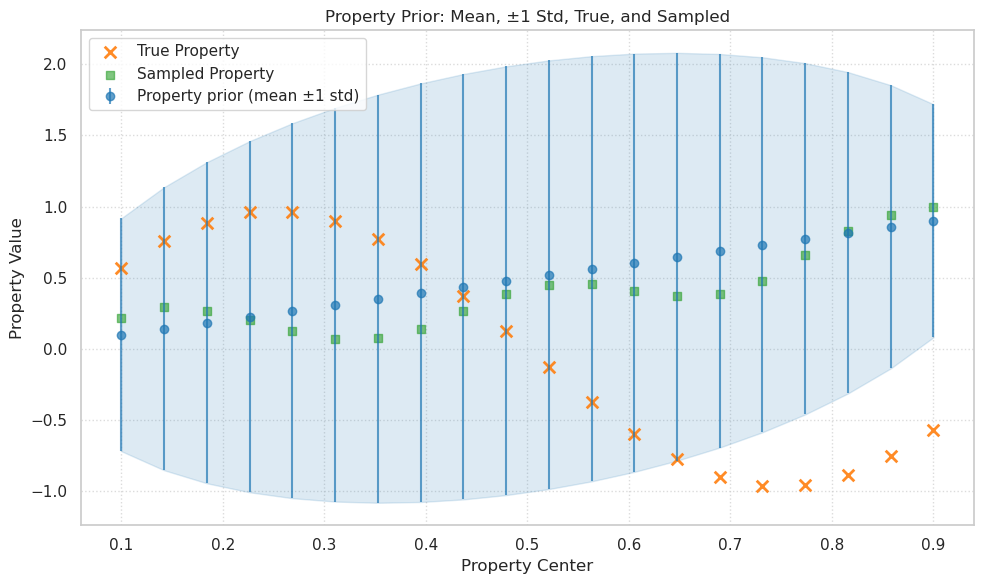

In [26]:
plt.figure(figsize=(10, 6))

# Plot the property mean with error bars and shaded region
mean_prop = T(M.gaussian_measure.expectation)
plt.errorbar(centers, mean_prop, yerr=std_P, fmt='o', color='tab:blue', alpha=0.7, label='Property prior (mean ±1 std)')
plt.fill_between(centers, mean_prop - std_P, mean_prop + std_P, color='tab:blue', alpha=0.15)

# Plot the true property
plt.scatter(centers, T(m_bar), label='True Property', color='tab:orange', marker='x', s=70, alpha=0.9, linewidths=2)

# Plot a sampled property
plt.scatter(centers, prior_P.sample(), label='Sampled Property', color='tab:green', marker='s', s=40, alpha=0.6)

plt.xlabel('Property Center')
plt.ylabel('Property Value')
plt.title('Property Prior: Mean, ±1 Std, True, and Sampled')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## Compute model posterior measure

In [27]:
solver = CholeskySolver()
normal_op = G @ C_0 @ G.adjoint + gaussian_D.covariance
normal_op_inv = solver(normal_op)
idk = C_0 @ G.adjoint @ normal_op_inv
C_M = C_0 - idk @ G @ C_0
m_tilde = m_0 + idk(d_tilde - G(m_0))
mu_M = GaussianMeasure.from_covariance_matrix(M, C_M.matrix(dense=True), expectation=m_tilde)

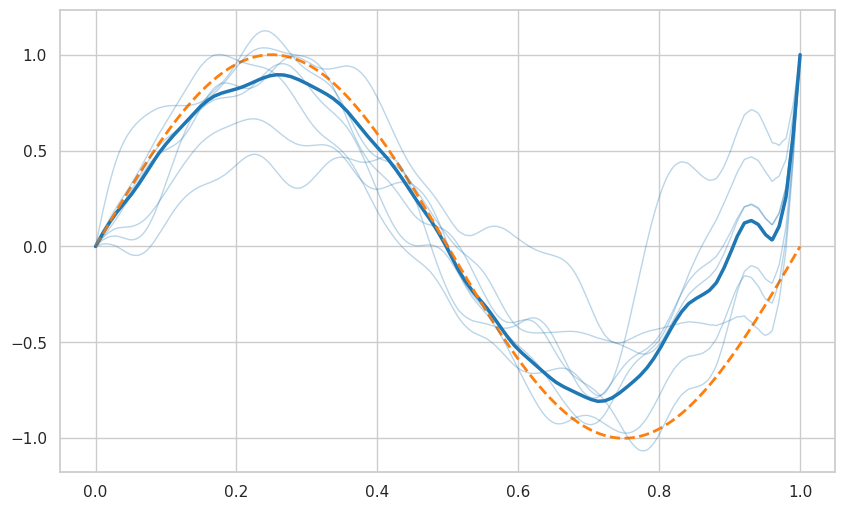

In [28]:
# Now we can visualize the posterior measure on the model space
plt.figure(figsize=(10, 6))
plt.plot(x, mu_M.expectation.evaluate(x), color='tab:blue', linewidth=2.5, label='Posterior Mean')
plt.plot(x, m_bar.evaluate(x), color='tab:orange', linestyle='--', linewidth=2, label='True Model')
# Plot a few samples from the posterior measure
for _ in range(num_samples):
    plt.plot(x, mu_M.sample().evaluate(x), color=sample_color, alpha=0.3, linewidth=1, label='Sample' if _ == 0 else "")

## Compute property posterior measure

In [29]:
p_tilde = T(m_0) + (T @ C_0 @ G.adjoint @ normal_op_inv)(d_tilde - G(m_0))
cov_P = T @ C_M @ T.adjoint

In [30]:
gaussian_P = GaussianMeasure.from_covariance_matrix(P, cov_P.matrix(dense=True), expectation=p_tilde)

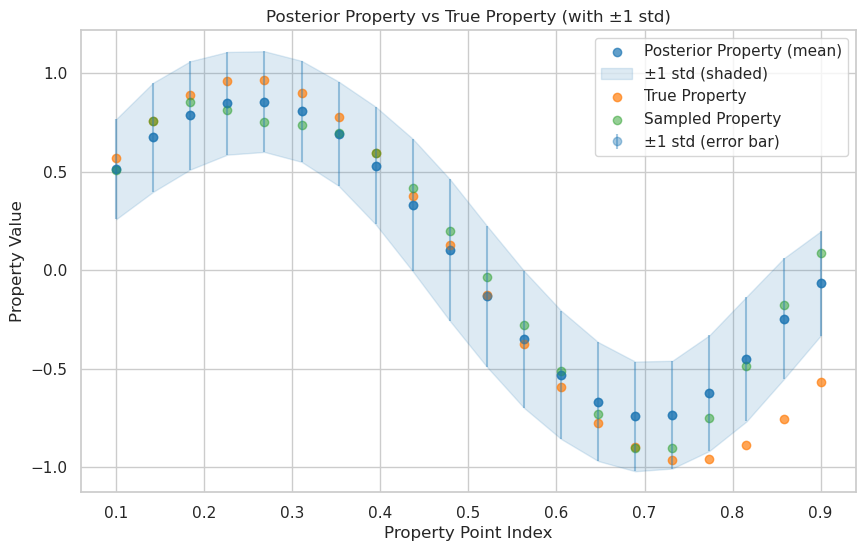

In [31]:
std_P = np.sqrt(np.diag(gaussian_P.covariance.matrix(dense=True)))
plt.figure(figsize=(10, 6))
plt.scatter(centers, p_tilde, label='Posterior Property (mean)', color='tab:blue', alpha=0.7)
plt.errorbar(centers, p_tilde, yerr=std_P, fmt='o', color='tab:blue', alpha=0.4, label='±1 std (error bar)')
plt.fill_between(centers, p_tilde - std_P, p_tilde + std_P, color='tab:blue', alpha=0.15, label='±1 std (shaded)')
plt.scatter(centers, T(m_bar), label='True Property', color='tab:orange', alpha=0.7)
plt.scatter(centers, gaussian_P.sample(), label='Sampled Property', color='tab:green', alpha=0.5)
plt.xlabel('Property Point Index')
plt.ylabel('Property Value')
plt.title('Posterior Property vs True Property (with ±1 std)')
plt.legend()
plt.show()